In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os

# modify the project path below accordingly
PATH = "/content/drive/MyDrive/HGR/gesture_face_features"

sys.path.append(os.path.join(PATH, "code", "main"))

data_path = os.path.join(PATH, 'samples', 'sign')
feat_path = os.path.join(PATH, 'data', 'feats')

%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

# loading modules from system path
from loader import SignImageFolder, ModelLoader
from participant import participants, filter_participants, filter_targets
from feature import extract_features, extract_model_features
from feature import filter_by_id, get_f_y_pred
from utils import get_predictions, decode_imagenet, delete_keys, keep_fc
from mte import get_leep_score, get_nleep_score, score_MTE, LogME

# used often
MODEL_ZOO = ModelLoader.available_models

In [4]:
dataset = SignImageFolder(data_path, resize=(528,528))
dataloader = DataLoader(dataset, batch_size=32, num_workers=2)
# have separate dataloader for each model based on input_size
# and recalculate features with extract_features()

In [5]:
feats = extract_model_features(dataloader, feat_path=feat_path)

Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/vgg19_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/resnet50_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/inception_v3_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/efficientnet_b0_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/efficientnet_b1_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/efficientnet_b6_feats.pt.


In [6]:
for model_name in MODEL_ZOO:
  _, _, _, idx = get_f_y_pred(model_name, feats, dataset.targets)
  label_counts, _ = decode_imagenet(idx)
  print(f'Predictions of {model_name}: {label_counts}')

Predictions of vgg19: {'jersey': 67, 'sweatshirt': 62, 'suit': 34, 'military_uniform': 33, 'cardigan': 4, 'wig': 4, 'abaya': 2}
Predictions of resnet50: {'suit': 113, 'wool': 37, 'jersey': 28, 'wig': 25, 'sunglasses': 2, 'safety_pin': 1}
Predictions of inception_v3: {'jersey': 50, 'wool': 45, 'sweatshirt': 35, 'suit': 27, 'wig': 23, 'Band_Aid': 10, 'velvet': 5, 'sunglasses': 4, 'tench': 3, 'maillot': 2, 'abaya': 1, 'bow_tie': 1}
Predictions of efficientnet_b0: {'sweatshirt': 62, 'suit': 34, 'military_uniform': 34, 'abaya': 32, 'wig': 30, 'jersey': 11, 'wool': 3}
Predictions of efficientnet_b1: {'jersey': 40, 'sweatshirt': 37, 'wool': 37, 'suit': 34, 'abaya': 29, 'necklace': 23, 'perfume': 3, 'sunglasses': 2, 'wig': 1}
Predictions of efficientnet_b6: {'sweatshirt': 66, 'jersey': 38, 'wool': 37, 'suit': 28, 'cardigan': 18, 'wig': 18, 'abaya': 1}


# UMAP

In [7]:
# https://umap-learn.readthedocs.io/en/latest/
!pip install -q umap-learn

Our goal is to reduce the dimensionality of 'avgpool' layer features with the help of UMAP, cluster them with Kmeans (or Gaussian Mixture Model) and see if similar letters are combined together. Maybe we will find LEEP scores (akin to NLEEP) for ranking.

In [13]:
# Deletes all features except for avgpool to free RAM
# for model_name in MODEL_ZOO:
#   delete_keys(feats[model_name], keep_key_list=['avgpool'])

In [8]:
# splitting feats based on participants
p = filter_participants(feats, dataset)
t = filter_targets(dataset)
del feats # frees up RAM

In [14]:
import umap
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid

import warnings
warnings.simplefilter("ignore", FutureWarning)

class Reducer:
  def __init__(self, feats, targets, model_name, layer_name, method='umap', n_components=2, random_state=None):
    self.feats = feats
    self.targets = targets
    self.model_name = model_name
    self.layer_name = layer_name
    self.random_state = random_state
    self.n_components = n_components
    self.embedding = None
    self.params = None
    self.method = method
    self.layer_feats = self._get_layer_feats()

  def _get_layer_feats(self):
    layer_feats = self.feats[self.model_name][self.layer_name]
    return layer_feats.view(layer_feats.shape[0], -1)

  def get_embedding(self, params=None):
    print(params)
    if self.method == 'umap':
      self.params = params or {
        'n_neighbors': 30,
        'min_dist': 0.3,
        'metric': 'euclidean',
      }
      reducer = umap.UMAP(
        n_components=self.n_components,
        n_neighbors=self.params['n_neighbors'],
        min_dist=self.params['min_dist'],
        metric=self.params['metric'],
        random_state=self.random_state
      )
    elif self.method == 'tsne':
      self.params = params or {
        'perplexity': 10,
        'learning_rate': 300,
        'metric': 'euclidean',
      }
      reducer = TSNE(
        n_components=self.n_components,
        perplexity=self.params['perplexity'],
        learning_rate=self.params['learning_rate'],
        metric=self.params['metric'],
        random_state=self.random_state
      )

    self.embedding = reducer.fit_transform(self.layer_feats)

  def plot(self):
    plt.scatter(
      self.embedding[:, 0],
      self.embedding[:, 1],
      c = self.targets
    )

  def __repr__(self):
    return f"Embedding shape: {self.embedding.shape}, {self.method} params: {self.params})"

class ReducerEngine:
  def __init__(self, feats, targets, method='umap', param_grids=None, n_components=2, random_state=None):
    self.feats = feats
    self.targets = targets
    self.method = method
    self.param_grids = param_grids or {
      'umap': {
        'n_neighbors': [5, 10, 15, 30],
        'min_dist': [0.01, 0.05, 0.1, 0.3],
        'metric': ["euclidean", "cosine"]
      },
      'tsne': {
        'perplexity': [10, 15, 20, 25],
        'learning_rate': [100, 300, 600, 1000],
        'metric': ["euclidean", "cosine"]
      }
    }
    self.n_components = n_components
    self.random_state = random_state
    self.embeddings = {}

  def get_all_embeddings(self, model_name_list, layer_name_list):
    print(f'Getting {self.method} embeddings for grid {self.param_grids[self.method]}.')
    for model_name in model_name_list:
      self.embeddings[model_name] = {}
      for layer_name in layer_name_list:
        print(f'-------- {model_name} {layer_name} ---------')
        if layer_name in self.feats[model_name].keys():
          self.embeddings[model_name][layer_name] = {}
          for params in ParameterGrid(self.param_grids[self.method]):
            reducer = Reducer(self.feats, self.targets, model_name, layer_name, self.method, self.n_components, self.random_state)
            reducer.get_embedding(params)
            self.embeddings[model_name][layer_name] = reducer

In [15]:
ModelLoader.return_nodes_dict

{'vgg19': ['features.34',
  'features.35',
  'features.36',
  'avgpool',
  'classifier.6'],
 'resnet50': ['layer4.2.conv3', 'layer4.2.relu_2', 'avgpool', 'fc'],
 'inception_v3': ['Mixed_7c.branch_pool.conv', 'avgpool', 'fc'],
 'efficientnet_b0': ['features.8', 'avgpool', 'classifier.1'],
 'efficientnet_b1': ['features.8', 'avgpool', 'classifier.1'],
 'efficientnet_b6': ['features.8', 'avgpool', 'classifier.1']}

In [18]:
LAYER_ZOO = ['avgpool', 'features.8', 'layer4.2.conv3', 'features.34']

In [16]:
num = 5
re_umap = ReducerEngine(p[num], t[num])
re_umap.get_all_embeddings(MODEL_ZOO, LAYER_ZOO)

Getting umap embeddings for grid {'n_neighbors': [5, 10, 15, 30], 'min_dist': [0.01, 0.05, 0.1, 0.3], 'metric': ['euclidean', 'cosine']}.
-------- vgg19 avgpool ---------
{'metric': 'euclidean', 'min_dist': 0.01, 'n_neighbors': 5}
{'metric': 'euclidean', 'min_dist': 0.01, 'n_neighbors': 10}
{'metric': 'euclidean', 'min_dist': 0.01, 'n_neighbors': 15}
{'metric': 'euclidean', 'min_dist': 0.01, 'n_neighbors': 30}
{'metric': 'euclidean', 'min_dist': 0.05, 'n_neighbors': 5}
{'metric': 'euclidean', 'min_dist': 0.05, 'n_neighbors': 10}
{'metric': 'euclidean', 'min_dist': 0.05, 'n_neighbors': 15}
{'metric': 'euclidean', 'min_dist': 0.05, 'n_neighbors': 30}
{'metric': 'euclidean', 'min_dist': 0.1, 'n_neighbors': 5}
{'metric': 'euclidean', 'min_dist': 0.1, 'n_neighbors': 10}
{'metric': 'euclidean', 'min_dist': 0.1, 'n_neighbors': 15}
{'metric': 'euclidean', 'min_dist': 0.1, 'n_neighbors': 30}
{'metric': 'euclidean', 'min_dist': 0.3, 'n_neighbors': 5}
{'metric': 'euclidean', 'min_dist': 0.3, 'n_n

In [36]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from collections import Counter

class Embedding:
  def __init__(self, reducer, model='kmeans', random_state=None):
    self.reducer = reducer
    self.random_state = random_state
    self.model = model
    self.cluster = None

  def get_clusters(self):
    n_clusters = len(np.unique(self.reducer.targets))
    if self.model == 'kmeans':
      model = KMeans(n_clusters=n_clusters, random_state=self.random_state)
    elif self.model == 'gmm':
      model = GaussianMixture(n_components=n_clusters, random_state=self.random_state)

    self.cluster = model.fit_predict(self.reducer.embedding)

  def print(self):
    data = np.column_stack((self.cluster, self.reducer.targets))

    cluster_groups = {}
    for cluster, letter in data:
        cluster_groups.setdefault(cluster, []).append(letter)

    print("Cluster Grouping Results:")
    for cluster, letter_group in cluster_groups.items():
        print(f"Cluster {cluster}: {letter_group} (Counts: {Counter(letter_group)})")

    total_samples = len(self.reducer.targets)
    purity = sum(max(Counter(letter_group).values()) for letter_group in cluster_groups.values()) / total_samples
    print(f"\nPurity of Clustering: {purity:.2f}")

  def __repr__(self):
    return f"Embedding for {self.model}"


class EmbeddingEngine:
  def __init__(self, reducer_engine, model='kmeans', random_state=None):
    self.reducer_engine = reducer_engine
    self.random_state = random_state
    self.model = model
    self.clusters = {}

  def get_all_clusters(self, model_name_list, layer_name_list):
    print(f'Getting {self.model} clusters:')
    for model_name in model_name_list:
      self.clusters[model_name] = {}
      for layer_name in layer_name_list:
        if layer_name in self.reducer_engine.embeddings[model_name].keys():
          print(f'-------- {model_name} {layer_name} ---------')
          reducer = self.reducer_engine.embeddings[model_name][layer_name]
          cluster = Embedding(reducer, self.model, self.random_state)
          cluster.get_clusters()
          self.clusters[model_name][layer_name] = cluster

In [37]:
ee_kmeans = EmbeddingEngine(re_umap)
ee_kmeans.get_all_clusters(MODEL_ZOO, LAYER_ZOO)

Getting kmeans clusters:
-------- vgg19 avgpool ---------
-------- vgg19 features.34 ---------
-------- resnet50 avgpool ---------
-------- resnet50 layer4.2.conv3 ---------
-------- inception_v3 avgpool ---------
-------- efficientnet_b0 avgpool ---------
-------- efficientnet_b0 features.8 ---------
-------- efficientnet_b1 avgpool ---------
-------- efficientnet_b1 features.8 ---------
-------- efficientnet_b6 avgpool ---------
-------- efficientnet_b6 features.8 ---------


In [40]:
for model_name in MODEL_ZOO:
  for layer_name in LAYER_ZOO:
    if layer_name in  ee_kmeans.clusters[model_name].keys():
      ee_kmeans.clusters[model_name][layer_name].print()
      print('----------------------------------------')

Cluster Grouping Results:
Cluster 6: [4, 4, 0] (Counts: Counter({4: 2, 0: 1}))
Cluster 4: [4, 4, 4, 0] (Counts: Counter({4: 3, 0: 1}))
Cluster 5: [4, 4, 6, 6, 3] (Counts: Counter({4: 2, 6: 2, 3: 1}))
Cluster 3: [6, 6, 0, 0] (Counts: Counter({6: 2, 0: 2}))
Cluster 0: [6, 6, 6, 3, 3, 3, 3, 0] (Counts: Counter({3: 4, 6: 3, 0: 1}))
Cluster 1: [2, 2, 1, 1, 1] (Counts: Counter({1: 3, 2: 2}))
Cluster 2: [2, 2, 2, 5, 5, 5, 5, 5, 5, 1] (Counts: Counter({5: 6, 2: 3, 1: 1}))

Purity of Clustering: 0.56
----------------------------------------
Cluster Grouping Results:
Cluster 4: [4, 4, 4, 4, 0, 0] (Counts: Counter({4: 4, 0: 2}))
Cluster 0: [4, 4, 6, 6, 3] (Counts: Counter({4: 2, 6: 2, 3: 1}))
Cluster 2: [4, 6, 3, 3, 3, 3, 0] (Counts: Counter({3: 4, 4: 1, 6: 1, 0: 1}))
Cluster 3: [6, 6, 6, 0, 0] (Counts: Counter({6: 3, 0: 2}))
Cluster 5: [6, 2, 2, 2, 5, 5] (Counts: Counter({2: 3, 5: 2, 6: 1}))
Cluster 1: [2, 2, 5, 5, 5, 5, 1] (Counts: Counter({5: 4, 2: 2, 1: 1}))
Cluster 6: [1, 1, 1] (Counts: Coun

In [304]:
emb.print('gmm')

Cluster Grouping Results:
Cluster 4: [4, 4, 4, 6, 6] (Counts: Counter({4: 3, 6: 2}))
Cluster 2: [4, 4, 4, 0, 0] (Counts: Counter({4: 3, 0: 2}))
Cluster 1: [4, 6, 6, 6, 3, 3, 0, 0, 0] (Counts: Counter({6: 3, 0: 3, 3: 2, 4: 1}))
Cluster 5: [6, 6, 3, 3, 3] (Counts: Counter({3: 3, 6: 2}))
Cluster 3: [2, 2, 2, 2, 5] (Counts: Counter({2: 4, 5: 1}))
Cluster 0: [2, 5, 5, 5, 5, 5, 1] (Counts: Counter({5: 5, 2: 1, 1: 1}))
Cluster 6: [1, 1, 1] (Counts: Counter({1: 3}))

Purity of Clustering: 0.62


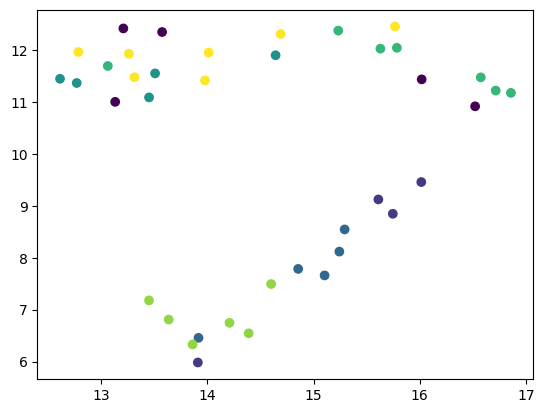

In [299]:
reducer.plot()

In [87]:
!git clone -q https://github.com/thuml/LogME.git

In [92]:
from LogME.LEEP import LEEP

num_components_gmm = 7
gmm = GaussianMixture(n_components=num_components_gmm, random_state=random_state)
gmm.fit(embedding)
gmm_predictions = gmm.predict_proba(embedding)
nleep = LEEP(gmm_predictions, t[p_num])
print(f"NLEEP score: {nleep}")

NLEEP score: -0.6945915657439539


In [122]:
num_components_gmm = 39
gmm = GaussianMixture(n_components=num_components_gmm, random_state=random_state)
gmm.fit(embedding)
gmm_predictions = gmm.predict_proba(embedding)
nleep = LEEP(gmm_predictions, t[p_num])
print(f"NLEEP score: {nleep}")

NLEEP score: 0.0


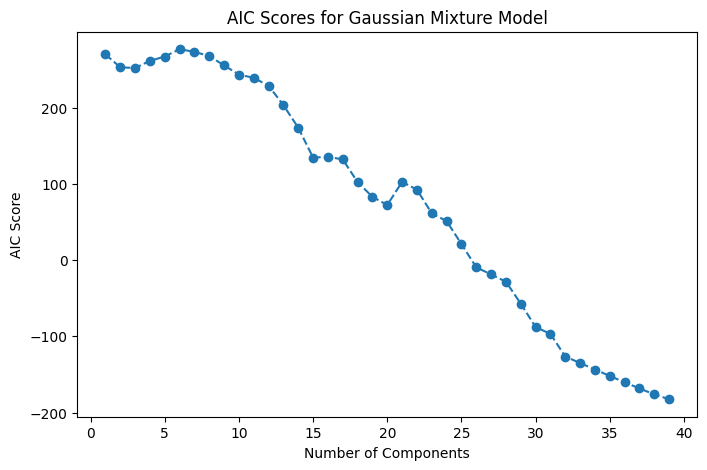

In [121]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


n_components_range = range(1, 40)
aic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(embedding)
    aic_scores.append(gmm.aic(embedding))

# Plot AIC scores
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, aic_scores, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("AIC Score")
plt.title("AIC Scores for Gaussian Mixture Model")
plt.show()


# Model Transferability Estimation

https://github.com/thuml/Transfer-Learning-Library/tree/master/examples/model_selection

In [ ]:
# targets = np.array(dataset.targets, dtype=np.int32)
# for model_name in MODEL_ZOO:
#   fc_layer = list(feats[model_name].keys())[-1]
#   f = feats[model_name][fc_layer]
#   # preds = F.softmax(f, dim=1).numpy()
#   score = get_nleep_score(f, targets, 35)
#   print(f'NLEEP score for {model_name}: {score}')

NLEEP score for vgg19: -1.1026206016540527
NLEEP score for resnet50: -1.0406854152679443
NLEEP score for inception_v3: -1.1728464365005493
NLEEP score for efficientnet_b0: -1.062324047088623
NLEEP score for efficientnet_b1: -1.0187960863113403
NLEEP score for efficientnet_b6: -1.144242525100708


In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.mixture import GaussianMixture
# import numpy as np

# random_state = 42
# num_components_pca = 35  # Number of components for PCA (adjust as needed)

# targets = np.array(dataset.targets, dtype=np.int32)
# for model_name in MODEL_ZOO:
#   fc_layer = list(feats[model_name].keys())[-1]
#   f = feats[model_name][fc_layer]
#   # preds = F.softmax(f, dim=1).numpy()
#   pca = PCA(n_components=num_components_pca, random_state=random_state)
#   reduced_features = pca.fit_transform(f)

#   explained_variance_ratio = pca.explained_variance_ratio_
#   pca_energy = np.cumsum(explained_variance_ratio)

#   num_components_gmm = 35
#   gmm = GaussianMixture(n_components=num_components_gmm, random_state=random_state)
#   gmm.fit(reduced_features)
#   gmm_predictions = gmm.predict_proba(reduced_features)
#   nleep = get_leep_score(gmm_predictions.astype('float32'), targets)
#   # print("PCA Explained Variance Ratio:", np.sum(pca.explained_variance_ratio_), pca_energy)
#   print(f"NLEEP Score for {model_name}: {nleep}")

NLEEP Score for vgg19: -1.0961130857467651
NLEEP Score for resnet50: -1.0729265213012695
NLEEP Score for inception_v3: -1.0495256185531616
NLEEP Score for efficientnet_b0: -1.0380001068115234
NLEEP Score for efficientnet_b1: -0.8942098617553711
NLEEP Score for efficientnet_b6: -1.0076889991760254


In [ ]:
!git clone -q https://github.com/thuml/LogME.git

In [ ]:
from LogME.LogME import LogME
from LogME.LEEP import LEEP
from LogME.NCE import NCE

In [ ]:
targets = np.array(dataset.targets)
for model_name in MODEL_ZOO:
  fc_layer = list(feats[model_name].keys())[-1]
  f = feats[model_name][fc_layer]
  preds = F.softmax(f, dim=1).numpy()
  score = LEEP(preds, targets)
  print(f'LEEP score for {model_name}: {score}')

LEEP score for vgg19: -1.92770825355806
LEEP score for resnet50: -1.9434076109575982
LEEP score for inception_v3: -1.9360990636225066
LEEP score for efficientnet_b0: -1.9289171695876328
LEEP score for efficientnet_b1: -1.9320151866958826
LEEP score for efficientnet_b6: -1.9137111650971603


In [ ]:
logme = LogME()

targets = np.array(dataset.targets)
for model_name in MODEL_ZOO:
  fc_layer = list(feats[model_name].keys())[-1]
  f = feats[model_name][fc_layer]
  preds = F.softmax(f, dim=1).numpy()
  score = logme.fit(preds, targets)
  print(f'LogME score for {model_name}: {score}')

LogME score for vgg19: -2.257169256187553
LogME score for resnet50: -5.491077958443078
LogME score for inception_v3: -6.446164371475224


/content/LogME/LogME.py:172: UserWarning: re-fitting for new data. old parameters cleared.
  warnings.warn('re-fitting for new data. old parameters cleared.')


LogME score for efficientnet_b0: 3.0739671979375203
LogME score for efficientnet_b1: 0.640813031838806
LogME score for efficientnet_b6: 1.2337664315449643


In [ ]:
# p = filter_participants(feats, dataset)
# t = filter_targets(dataset)

In [ ]:
# for i in range(6):
#   print(f'Participant {i}')
#   for model_name in MODEL_ZOO:
#     fc_layer = list(p[i][model_name].keys())[-1]
#     f = p[i][model_name][fc_layer]
#     preds = F.softmax(f, dim=1).numpy()
#     score = LEEP(preds, t[i])
#     print(f'LEEP score for {model_name}: {score}')
#   print()